In [1]:
# Import relevant modules
%pylab inline
import numpy
import scipy.optimize
import scipy.stats
import matplotlib.ticker as ticker

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Chi-squared minimisation with 2 fitting parameters

Input the experimental data with errors - for example, can copy/paste lists produced by ``Pendulum_Analysis`` Notebook. 

Ensure that all arrays have the same length.

In [2]:

xval = numpy.array([0, 15, 30, 45, 60])
yval = numpy.array([69.92679983449095, 77.288051092258044, 83.438779433156554, 90, 100])
yerr = numpy.array([0.29155443483946492, 0.30827638126707702, 0.24198531951798319,1, 1.2])

assert len(yval) == len(xval)
assert len(yerr) == len(yval)

Define the functional form of the model: ``vals`` is a numpy array holding the parameter values, here intercept and slope.

In [3]:

def model_funct(x, vals):
    return vals[0] + vals[1]*x

Define initial values for fitting parameters and calculate degrees of freedom.

In [4]:

initial = numpy.array([0.0, 1.0]) # Initial guess for fit parameters
deg_freedom = xval.size - initial.size # Make sure you understand why!
print('DoF = {}'.format(deg_freedom))

DoF = 3


Define a function that calculates chi-squared for the model function (``model_funct``, defined above), given a set of parameter values and data set with errors.

In [5]:

def chisq(modelparams, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(xval)):
        chisqval += ((y_data[i] - model_funct(x_data[i], modelparams))/y_err[i])**2
    return chisqval

Produce a fit using the scipy optimize sub-module: 

``chisq`` is the function to be minimised - defined above, in this case giving chi-squared

``initial`` is a numpy array containing the initial 'guessed' values of the parameters - defined above

``args`` are additional arguments to pass to the ``chisq`` function after the array of parameters - in this case the data.

There are many additional options that can be passed to the minimize function; see the ``scipy`` documentation - these are not required for the simple case here, but may be for more complex data. You will learn about how several of them work during your Computational Physics course.


In [6]:

fit = scipy.optimize.minimize(chisq, initial, args=(xval, yval, yerr))

# Termination output message is fit.message - did the minimisation complete successfully?
print(fit.message)

# Resulting best fit parameter array is output as fit.x
a_soln = fit.x[0]
b_soln = fit.x[1]

print('best fit a = {} a_units?'.format(a_soln))
print('best fit b = {} b_units?'.format(b_soln))

# minimized value for chisq function is fit.fun
print('minimised chi-squared = {}'.format(fit.fun))

# Take a moment at this point to think about significant figures...

Optimization terminated successfully.
best fit a = 69.99350850040227 a_units?
best fit b = 0.4577361001366409 b_units?
minimised chi-squared = 8.22774570152555


Calculate the minimized value of chi-squared again as a demonstration; this time using the ``chisq`` function directly, and best fit parameter values. Result should be the same as above...

In [7]:

chisq_min = chisq([a_soln, b_soln], xval, yval, yerr)
print('chi^2_min = {}'.format(chisq_min))

chi^2_min = 8.22774570152555


Calculate the reduced chi-squared value from minimized chi-squared 

In [8]:

chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

reduced chi^2 = 2.7425819005085166


Calculate the 'P-value', as described in Skills 1 & 2. ``scipy.stats.chi2.sf`` is the Python equivalent of ``chidist`` in Excel. 

In [9]:

P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print('$P(chi^2_min, DoF)$ = {}'.format(P))

$P(chi^2_min, DoF)$ = 0.04153207228385709


Plot the data and best fit - data should have error-bars and no joining lines, fit is shown by a solid line.


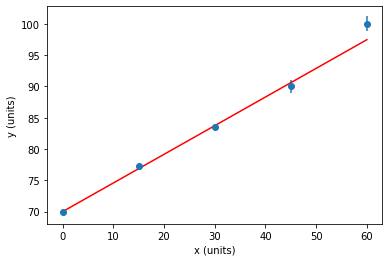

In [10]:

pyplot.figure()
pyplot.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None')

# Axis labels
pyplot.xlabel('x (units)')
pyplot.ylabel('y (units)')

# Generate best fit line using model function and best fit parameters, and add to plot
fit_line=model_funct(xval, [a_soln, b_soln])
pyplot.plot(xval, fit_line, 'r')

# Set suitable axis limits: you will probably need to change these...
#pyplot.xlim(-1, 61)
#pyplot.ylim(65, 105)
pyplot.show()

# What about plotting the (normalised) residuals?

In the many cases where ``model_funct`` may not describe a straight line, the line of best fit used likely appears jagged as values are only calculated and plotted at positions corresponding to the measured values of the independent variable. We can produce a smoother curve by interpolation using our optimised parameter values and model function to calculate the line of best fit at intermediate points.

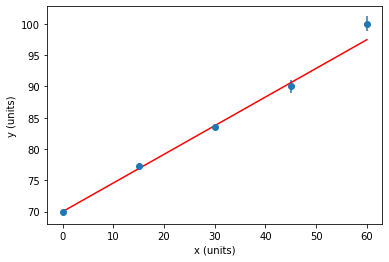

In [11]:

smooth_xval = numpy.linspace(xval[0], xval[-1], 1000)   # make a smoother line - use 1000 equally spaced 
                                                        # points over the range of the 39 measured points.
pyplot.figure()
pyplot.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None')

pyplot.xlabel('x (units)')
pyplot.ylabel('y (units)')

simulated_line = model_funct(smooth_xval, [a_soln, b_soln]) 
pyplot.plot(smooth_xval, simulated_line, 'r')
pyplot.show()


Generate data for 2D plots of the chi squared landscape. 
Note that this is not a very computationally efficient approach, so unsuited to more complex problems.
It will also only work 'correctly' for a 2-parameter fit...

``a_low``, ``a_high``, ``b_low``, and ``b_high`` are the axis ranges for 2D plot - adjust these to suit.

In [12]:

a_low, a_high = a_soln-1, a_soln+1 
b_low, b_high = b_soln-0.05, b_soln+0.05 

# Generate grid and data
da = (a_high - a_low)/1000.0
db = (b_high - b_low)/1000.0
a_axis = numpy.arange(a_low, a_high, da)
b_axis = numpy.arange(b_low, b_high, db)
plot_data = numpy.zeros((len(a_axis), len(b_axis)))
for i, bval in enumerate(b_axis):
    for j, aval in enumerate(a_axis):
        plot_data[i][j] = chisq([aval, bval], xval, yval, yerr)

As an example, produce a colour plot of chi-squared landscape.

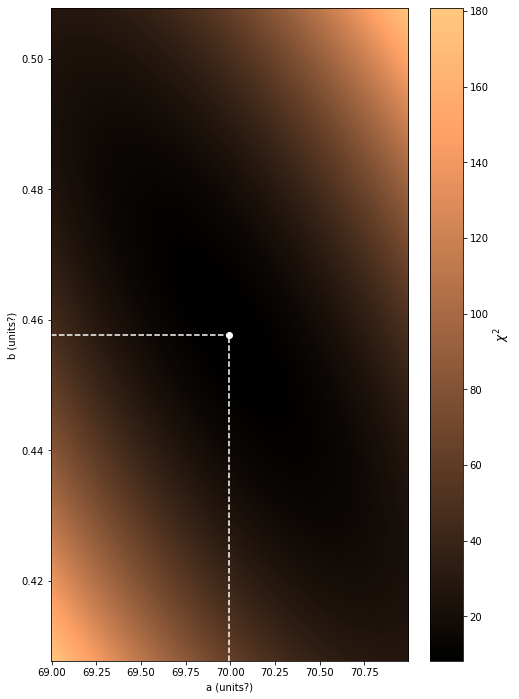

In [13]:

pyplot.figure(figsize=(8,12))
im = pyplot.imshow(plot_data, extent = (a_low, a_high, b_low, b_high), origin = 'lower', 
                   cmap=matplotlib.cm.copper, aspect='auto')
pyplot.ylim(b_low, b_high)
pyplot.xlim(a_low, a_high)

# Axis labels
pyplot.ylabel('b (units?)')
pyplot.xlabel('a (units?)')

# Colorbar and label
cbar=pyplot.colorbar(im, orientation = 'vertical')
cbar.set_label('$\chi^2$', fontsize=12)

# Add in best fit point and dashed lines
pyplot.plot(a_soln, b_soln, 'wo')
pyplot.plot((a_soln, a_soln), (b_low, b_soln), linestyle='--', color='w')
pyplot.plot((a_low, a_soln), (b_soln, b_soln), linestyle='--', color='w')
pyplot.show()

A more useful example: Produce a contour plot of 'delta chi-squared' (= chi-squared(a,b) - chi-squared_min).

Don't worry about 'unicode' warnings that may appear on the first run through.

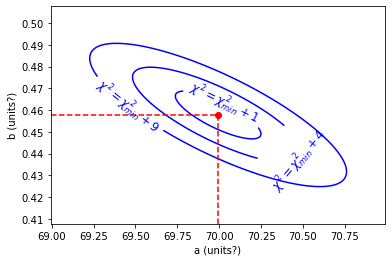

In [14]:

X, Y = numpy.meshgrid(a_axis, b_axis, indexing='xy')
contour_data = plot_data - chisq_min

# Contour levels to plot - delta chi-squared of 1, 4 & 9 correspond to 1, 2 & 3 standard deviations
levels = [1, 4, 9]
C_im = pyplot.contour(X, Y, contour_data, levels = levels, colors='b', origin = 'lower')
pyplot.clabel(C_im, levels, fontsize=12, inline=1, fmt=r'$\chi^2 = \chi^2_{min}+%1.0f$') 

# Axis labels
pyplot.xlabel('a (units?)')
pyplot.ylabel('b (units?)')

# This allows you to modify the tick markers to assess the errors from the chi-squared contour plots.
xtick_spacing = 0.25
ytick_spacing = 0.01

ax = pyplot.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(xtick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_spacing))


# Add in best fit point and dashed lines to axes
pyplot.plot(a_soln, b_soln, 'ro')
pyplot.plot((a_soln, a_soln), (b_low, b_soln), linestyle='--', color='r')
pyplot.plot((a_low, a_soln), (b_soln, b_soln), linestyle='--', color='r')
pyplot.show()

It is also possible to determine error bars from extrema of chi-squared+1 contour in 2D parameter space. 

In [ ]:

contours = C_im.collections[0].get_paths()    # Get hold of the contours from the plot
onesigma_contour = contours[0].vertices       # Grab the set of points constituting the one confidence 
                                              # interval contour
maxs = numpy.amax(onesigma_contour, axis=0)   # Get the extrema along the two axes - max and min values
mins = numpy.amin(onesigma_contour, axis=0)
errs = (maxs-mins)/2                          # Calculate one standard error in the parameters

a_err = errs[0]
b_err = errs[1]
a_err, b_err                                  

# Please do take another moment at this point to again think about significant figures...